Column names: Index(['MSFT', 'MSFT.1', 'MSFT.2', 'MSFT.3', 'GSPC', 'Date'], dtype='object')
Feature columns: ['MSFT', 'MSFT.1', 'MSFT.2', 'MSFT.3']
Target column: GSPC
Best Random Forest Parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}

Comparison Table:
  Metrics  Random Forest  Linear Regression
0     MAE      12.521790         106.326856
1     MSE     464.248447       16944.316352
2    RMSE      21.546425         130.170336
3      R2       0.996496           0.872103
Random Forest Accuracy: 1.00
Linear Regression Accuracy: 0.87


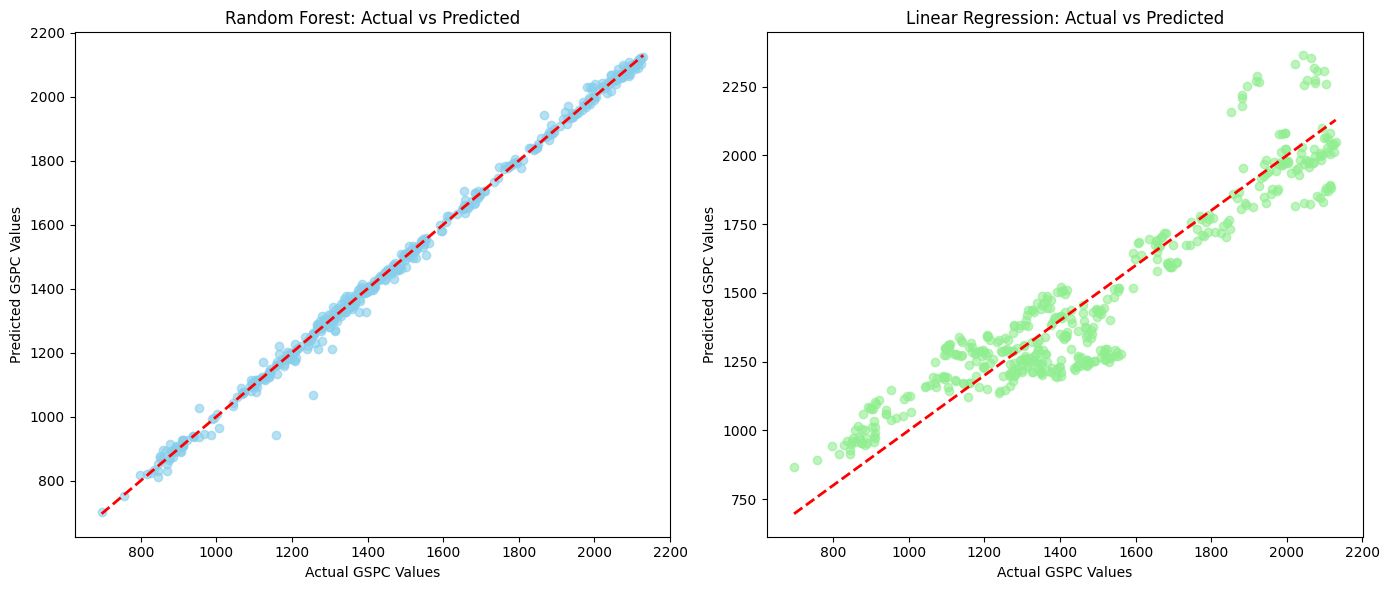

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset from CSV
df = pd.read_csv("/content/stock_data.csv")  # Update path to your actual file

# Print column names to confirm structure
print("Column names:", df.columns)

# Ensure the 'Date' column is in datetime format if present
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Identify feature and target columns (assuming GSPC is the target)
feature_columns = [col for col in df.columns if 'MSFT' in col]  # Dynamically capture MSFT-related columns
target_column = 'GSPC'  # Target column for S&P 500

# Print identified feature and target columns
print("Feature columns:", feature_columns)
print("Target column:", target_column)

# Feature and target separation
X = df[feature_columns]
y = df[target_column]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
lr_model = LinearRegression()

# Hyperparameter tuning for Random Forest using RandomizedSearchCV
param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomizedSearchCV with 5-fold cross-validation
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid_rf,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search_rf.fit(X_train, y_train)

# Best model for Random Forest
best_rf_model = random_search_rf.best_estimator_

# Training Linear Regression model
lr_model.fit(X_train, y_train)

# Predictions for both models
rf_predictions = best_rf_model.predict(X_test)
lr_predictions = lr_model.predict(X_test)

# Model evaluation function
def evaluate_model(y_test, predictions):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

# Evaluation metrics for Random Forest and Linear Regression
rf_metrics = evaluate_model(y_test, rf_predictions)
lr_metrics = evaluate_model(y_test, lr_predictions)

# Comparison table
comparison_df = pd.DataFrame({
    "Metrics": ["MAE", "MSE", "RMSE", "R2"],
    "Random Forest": [rf_metrics["MAE"], rf_metrics["MSE"], rf_metrics["RMSE"], rf_metrics["R2"]],
    "Linear Regression": [lr_metrics["MAE"], lr_metrics["MSE"], lr_metrics["RMSE"], lr_metrics["R2"]]
})

# Display the best parameters from RandomizedSearch for Random Forest and comparison table
best_rf_params = random_search_rf.best_params_
print("Best Random Forest Parameters:", best_rf_params)
print("\nComparison Table:")
print(comparison_df)

# Accuracy scores
rf_accuracy = best_rf_model.score(X_test, y_test)
lr_accuracy = lr_model.score(X_test, y_test)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Linear Regression Accuracy: {lr_accuracy:.2f}")

# Visualizing Predictions vs. Actual for both models as scatter plots
plt.figure(figsize=(14, 6))

# Scatter plot for Random Forest
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions, alpha=0.6, color="skyblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual GSPC Values')
plt.ylabel('Predicted GSPC Values')

# Scatter plot for Linear Regression
plt.subplot(1, 2, 2)
plt.scatter(y_test, lr_predictions, alpha=0.6, color="lightgreen")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual GSPC Values')
plt.ylabel('Predicted GSPC Values')

plt.tight_layout()
plt.show()
